## **Reading the Dataset**

In [ ]:
!unzip /content/dog_data.zip

Archive:  /content/dog_data_short.zip
   creating: dog_data/5898/
  inflating: dog_data/5898/5898_A_2zMUSqlxKlkAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5898/5898_A_2zMUSqlxKlkAAAAAAAAAAAAAAQAAAQ-0.jpg  
  inflating: dog_data/5898/5898_A_IdUASo3kSSUAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5898/5898_A_Km6WQabbG9cAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5898/5898_A_yFmGSo2bp-cAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5898/5898_A_YwS1QpL6r00AAAAAAAAAAAAAAQAAAQ.jpg  
   creating: dog_data/5899/
  inflating: dog_data/5899/5899_A__iVyQa-Ul-kAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5899/5899_A_1cY0SJWiw2gAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5899/5899_A_8PPFSJLo4y0AAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5899/5899_A_aYeATJcaX1MAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5899/5899_A_OQH-TZVbsjsAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: dog_data/5899/5899_A_rXoUTpGp2akAAAAAAAAAAAAAAQAAAQ.jpg  
   creating: dog_data/5901/
  inflating: dog_data/59

In [ ]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/content/dog_data"
IMAGE_SIZE = (128, 128)

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.resize(image, IMAGE_SIZE)  # Resize the image to 128x128
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders) * split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 90
Length of testing list : 10

Test List: {'5946': 9, '5964': 8, '5996': 9, '5915': 8, '5941': 8, '5924': 11, '5901': 8, '5960': 6, '5967': 7, '5911': 7}


### Creating Triplets

We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.

In [ ]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_files = list(os.listdir(os.path.join(directory, neg_folder)))
                neg_file = random.choice(neg_files)
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 2427
Number of testing triplets : 286

Examples of triplets:
(('5926', '5926_A_mwleR627z8oAAAAAAAAAAAAAAQAAAQ.jpg'), ('5926', '5926_A_eBxrT7u84_YAAAAAAAAAAAAAAQAAAQ.jpg'), ('5938', '5938_A_LUknQ5zwlPEAAAAAAAAAAAAAAQAAAQ.jpg'))
(('5999', '5999_A_Lzq7RaU4LI8AAAAAAAAAAAAAAQAAAQ.jpg'), ('5999', '5999_2A23mcKTRe6iwvdle-DnoQAAACMAARAD.jpg'), ('5985', '5985_A_uzHRSJ5nN_cAAAAAAAAAAAAAAQAAAQ.jpg'))
(('5983', '5983_A_lPjNSaZ7r9wAAAAAAAAAAAAAAQAAAQ.jpg'), ('5983', '5983_A_723fTJwuqewAAAAAAAAAAAAAAQAAAQ-0.jpg'), ('5989', '5989_A_fAd6Q6jPCKAAAAAAAAAAAAAAAQAAAQ.jpg'))
(('5947', '5947_A_02oeQZQGpSIAAAAAAAAAAAAAAQAAAQ-0.jpg'), ('5947', '5947_A_Y7LpQZ9WcMQAAAAAAAAAAAAAAQAAAQ.jpg'), ('5993', '5993_A_EL3MTLdLMz8AAAAAAAAAAAAAAQAAAQ.jpg'))
(('5962', '5962_A_8P78SYHj8vsAAAAAAAAAAAAAAQAAAQ.jpg'), ('5962', '5962_A_cUEKTLA6SR4AAAAAAAAAAAAAAQAAAQ.jpg'), ('5984', '5984_A_9z7ISKHMk40AAAAAAAAAAAAAAQAAAQ.jpg'))


### Creating Batch-Generator

Creating a **Batch-Generator** that converts the triplets passed into batches of face-data and **preproccesses** it before returning the data into seperate lists.

**Parameters:**
- Batch_size: Batch_size of the data to return
- Preprocess: Whether to preprocess the data or not

In [ ]:
def get_batch(triplet_list, batch_size=128, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

### Plotting the Data

Plotting the data generated from **get_batch()** to see the results

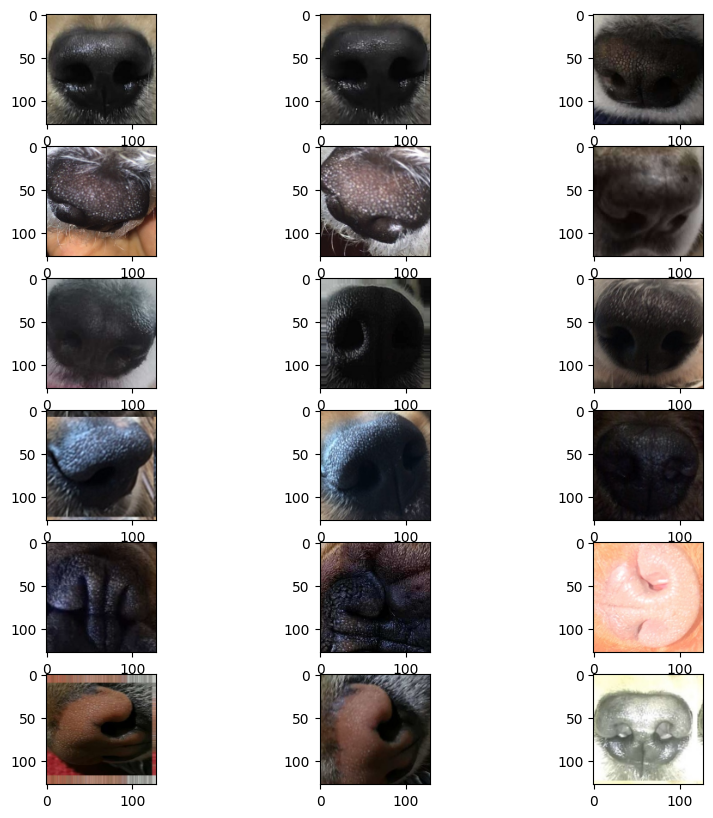

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(10, 10))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## **Creating the Model**

Unlike a conventional CNN, the **Siamese Network** does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Encoder

The **Encoder** is responsible for converting the passed images into their feature vectors. We're using a pretrained model, **Xception model** which is based on **Inception_V3 model.** By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to **Fully Connected (Dense)** layers and the last layer normalises the data using **L2 Normalisation**. *(L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)*

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

### Siamese Network

We're creating a **Siamese Network** that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between **(anchor, positive)** and **(anchor, negative)** pairs.

We'll be defining a custom layer to compute the distance.

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                   

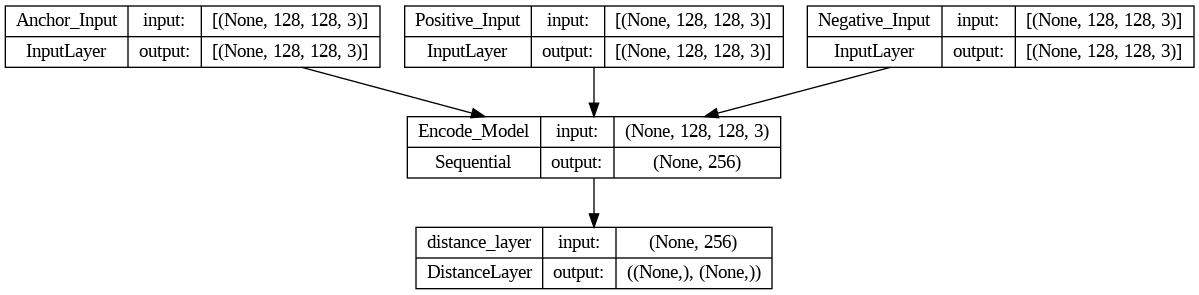

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Putting everything together

We now need to implement a model with custom training loop and loss function so we can compute the **triplet loss** using the three embeddings produced by the Siamese network.

We'll create a **Mean metric** instance to track the loss of the training process.

**Triplet Loss Function:**

<img src="https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png" alt="Loss Formula" width="400"/>

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## **Training the Model**

We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

### Test Function

**test_on_triplets()** function will be responsible for testing the model on test_triplets. It'll collect metrics **(accuracy, means, stds)** by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [ ]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
import time
import numpy as np

save_all = False
batch_size = 128
max_epochs = 256
patience = 20  # Number of epochs to wait for improvement
best_accuracy = 0
epochs_without_improvement = 0

train_loss = []
test_metrics = []

for epoch in range(1, max_epochs + 1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = np.mean(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Check if accuracy improved
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        if save_all:
            siamese_model.save_weights("siamese_model")
    else:
        epochs_without_improvement += 1

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping at epoch {epoch}, no improvement for {patience} epochs.")
        break


EPOCH: 1 	 (Epoch done in 65 sec)
Loss on train    = 0.31781
1/1 [==============================] - 5s 5s/step
Accuracy on test = 0.90210

EPOCH: 2 	 (Epoch done in 24 sec)
Loss on train    = 0.10250
1/1 [==============================] - 0s 36ms/step
Accuracy on test = 0.89860

EPOCH: 3 	 (Epoch done in 25 sec)
Loss on train    = 0.04867
1/1 [==============================] - 0s 35ms/step
Accuracy on test = 0.89161

EPOCH: 4 	 (Epoch done in 25 sec)
Loss on train    = 0.02368
1/1 [==============================] - 0s 41ms/step
Accuracy on test = 0.87762

EPOCH: 5 	 (Epoch done in 24 sec)
Loss on train    = 0.01390
1/1 [==============================] - 0s 36ms/step
Accuracy on test = 0.88462

EPOCH: 6 	 (Epoch done in 23 sec)
Loss on train    = 0.01004
1/1 [==============================] - 0s 34ms/step
Accuracy on test = 0.89161

EPOCH: 7 	 (Epoch done in 26 sec)
Loss on train    = 0.01039
1/1 [==============================] - 0s 36ms/step
Accuracy on test = 0.89510

EPOCH: 8 	 (Ep

In [ ]:
siamese_model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Siamese_Network (Functiona  ((None,),                 22043944  
 l)                           (None,))                           
                                                                 
Total params: 22043946 (84.09 MB)
Trainable params: 9583800 (36.56 MB)
Non-trainable params: 12460146 (47.53 MB)
_________________________________________________________________


## **Saving the Model Weights**


In [ ]:
# Saving the model weights as directly saving wont work here after all epochs run
siamese_model.save_weights("siamese_model_folder/siamese_model-final")

## Saving Model to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_name = 'SiameseNetwork'
folder_path = '/content/drive/My Drive/' + folder_name

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


Folder 'SiameseNetwork' created successfully.


In [ ]:
!cp -r "/content/encoder_folder" "/content/drive/MyDrive/SiameseNetwork"

In [ ]:
!cp -r "/content/siamese_model_folder" "/content/drive/MyDrive/SiameseNetwork"

## **Using the Model**

Now that we've finished training our model, we need to **extract the encoder** so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder_folder/" + "encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_24 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 lambda_4 (Lambda)           (None, 256)               0         
                                                      

### Classify Images

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 0s 35ms/step

Accuracy of model: 0.810546875



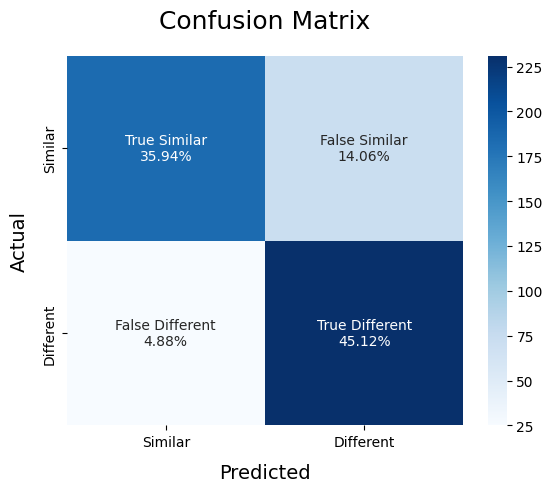

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)